In [14]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


from helper import *


In [15]:
# Define the dataset and dataloaders with data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:

# Create dataset instances
train_dataset = CelebCariDataset(root_dir='./Project/train', transform=train_transform)
val_dataset = CelebCariDataset(root_dir='./Project/validation', transform=transform)
test_dataset = CelebCariTestDataset(root_dir='./Project/test', transform=transform)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
class SimpleMultiLabelModel(nn.Module):
    def __init__(self, num_classes_identity, num_classes_style):
        super(SimpleMultiLabelModel, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False  # Freeze the backbone
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.fc_identity = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes_identity)
        )
        self.fc_style = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes_style)
        )

    def forward(self, x):
        features = self.backbone(x)
        identity_output = self.fc_identity(features)
        style_output = self.fc_style(features)
        return features, identity_output, style_output


num_classes_identity = 20
num_classes_style = 6
model = SimpleMultiLabelModel(num_classes_identity, num_classes_style)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

d:\Yaşar\Yazılım\Neural-Networks-With-Pytorch\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Yaşar\Yazılım\Neural-Networks-With-Pytorch\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Bahadır Erdem/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


SimpleMultiLabelModel(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

In [18]:
# Define the loss function and optimizer with higher weight decay
criterion_identity = nn.CrossEntropyLoss()
criterion_style = nn.CrossEntropyLoss()

def joint_loss(identity_output, style_output, identity_labels, style_labels, weight=0.5):
    loss_identity = criterion_identity(identity_output, identity_labels)
    loss_style = criterion_style(style_output, style_labels)
    return weight * loss_identity + (1 - weight) * loss_style

# Optimizer with higher weight decay and lower learning rate
optimizer = optim.Adam([
    {'params': model.fc_identity.parameters()},
    {'params': model.fc_style.parameters()}
], lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



In [50]:
num_epochs = 7
patience = 5

In [51]:
# Training loop with early stopping and tracking
best_model_wts = model.state_dict()
best_loss = float('inf')
early_stopping_counter = 0

# Lists to store the loss and accuracy values
train_losses, val_losses = [], []
train_identity_losses, val_identity_losses = [], []
train_style_losses, val_style_losses = [], []
train_identity_accuracies, val_identity_accuracies = [], []
train_style_accuracies, val_style_accuracies = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_loss_identity = 0.0
        running_loss_style = 0.0
        correct_identity = 0
        correct_style = 0
        total = 0

        for inputs, identity_labels, style_labels in dataloader:
            inputs = inputs.to(device)
            identity_labels = identity_labels.to(device)
            style_labels = style_labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                features, identity_output, style_output = model(inputs)
                loss = joint_loss(identity_output, style_output, identity_labels, style_labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_loss_identity += criterion_identity(identity_output, identity_labels).item() * inputs.size(0)
            running_loss_style += criterion_style(style_output, style_labels).item() * inputs.size(0)
            total += inputs.size(0)

            _, predicted_identity = torch.max(identity_output, 1)
            _, predicted_style = torch.max(style_output, 1)
            
            correct_identity += (predicted_identity == identity_labels).sum().item()
            correct_style += (predicted_style == style_labels).sum().item()

        epoch_loss = running_loss / total
        epoch_loss_identity = running_loss_identity / total
        epoch_loss_style = running_loss_style / total

        accuracy_identity = correct_identity / total
        accuracy_style = correct_style / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_identity_losses.append(epoch_loss_identity)
            train_style_losses.append(epoch_loss_style)
            train_identity_accuracies.append(accuracy_identity)
            train_style_accuracies.append(accuracy_style)
        else:
            val_losses.append(epoch_loss)
            val_identity_losses.append(epoch_loss_identity)
            val_style_losses.append(epoch_loss_style)
            val_identity_accuracies.append(accuracy_identity)
            val_style_accuracies.append(accuracy_style)

        print(f'{phase} Loss: {epoch_loss:.4f}')
        print(f'{phase} Identity Loss: {epoch_loss_identity:.4f}')
        print(f'{phase} Style Loss: {epoch_loss_style:.4f}')
        print(f'{phase} Identity Accuracy: {accuracy_identity:.4f}')
        print(f'{phase} Style Accuracy: {accuracy_style:.4f}')

        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, 'best_model.pth')
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

    scheduler.step()

    if early_stopping_counter >= patience:
        print("Early stopping")
        break


Epoch 0/6
----------
train Loss: 0.7203
train Identity Loss: 0.8577
train Style Loss: 0.5829
train Identity Accuracy: 0.8172
train Style Accuracy: 0.8250
val Loss: 2.1330
val Identity Loss: 3.6866
val Style Loss: 0.5793
val Identity Accuracy: 0.1042
val Style Accuracy: 0.8333
Epoch 1/6
----------
train Loss: 0.6615
train Identity Loss: 0.7779
train Style Loss: 0.5451
train Identity Accuracy: 0.8426
train Style Accuracy: 0.8471
val Loss: 2.1513
val Identity Loss: 3.7039
val Style Loss: 0.5988
val Identity Accuracy: 0.0833
val Style Accuracy: 0.7958
Epoch 2/6
----------
train Loss: 0.6156
train Identity Loss: 0.7072
train Style Loss: 0.5241
train Identity Accuracy: 0.8618
train Style Accuracy: 0.8505
val Loss: 2.0658
val Identity Loss: 3.5882
val Style Loss: 0.5433
val Identity Accuracy: 0.1625
val Style Accuracy: 0.8417
Epoch 3/6
----------
train Loss: 0.5904
train Identity Loss: 0.6688
train Style Loss: 0.5120
train Identity Accuracy: 0.8667
train Style Accuracy: 0.8529
val Loss: 2.152

In [56]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

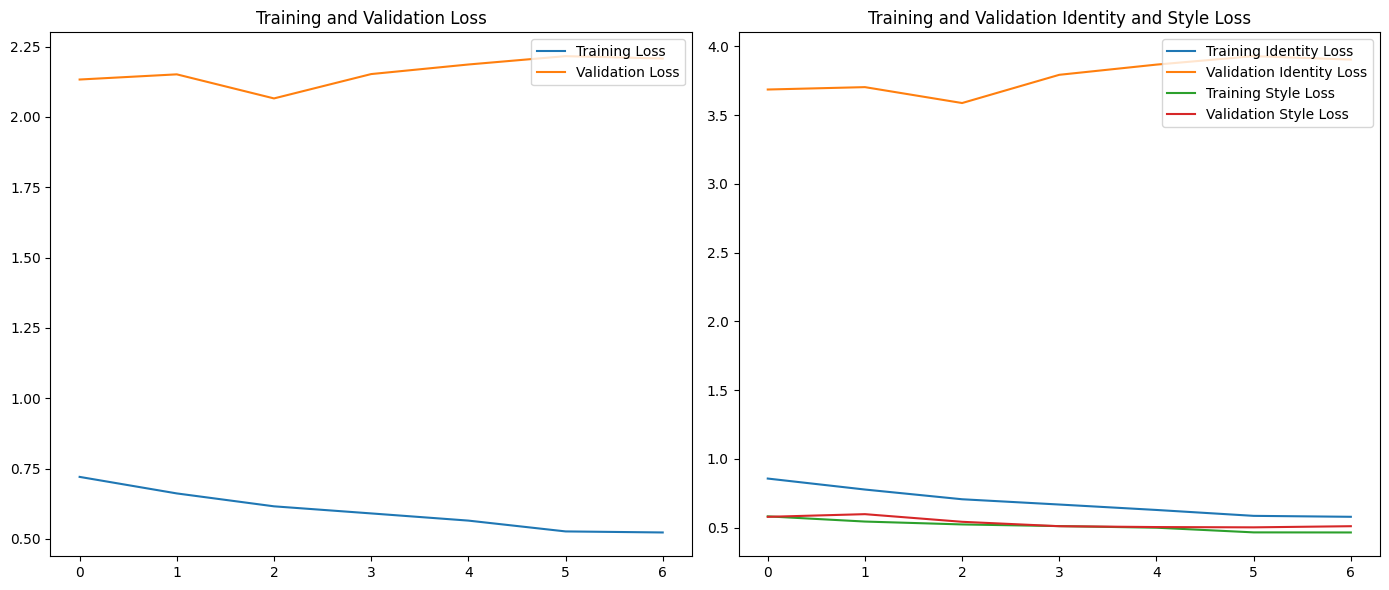

In [57]:

# Plotting the tracked metrics
epochs_range = range(num_epochs)
# Adjusting the lengths of epochs_range and metrics if needed
min_length = min(len(epochs_range), len(train_losses), len(val_losses), 
                 len(train_identity_losses), len(val_identity_losses), 
                 len(train_style_losses), len(val_style_losses), 
                 len(train_identity_accuracies), len(val_identity_accuracies),
                 len(train_style_accuracies), len(val_style_accuracies))

# Truncate all lists to the minimum length
epochs_range = epochs_range[:min_length]
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_identity_losses = train_identity_losses[:min_length]
val_identity_losses = val_identity_losses[:min_length]
train_style_losses = train_style_losses[:min_length]
val_style_losses = val_style_losses[:min_length]
train_identity_accuracies = train_identity_accuracies[:min_length]
val_identity_accuracies = val_identity_accuracies[:min_length]
train_style_accuracies = train_style_accuracies[:min_length]
val_style_accuracies = val_style_accuracies[:min_length]

# Plotting the losses
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_identity_losses, label='Training Identity Loss')
plt.plot(epochs_range, val_identity_losses, label='Validation Identity Loss')
plt.plot(epochs_range, train_style_losses, label='Training Style Loss')
plt.plot(epochs_range, val_style_losses, label='Validation Style Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Identity and Style Loss')

plt.tight_layout()
plt.show()




In [58]:
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [59]:
# Create and Save Gallery Embeddings Using the Validation Dataset
train_gallery = create_gallery_embeddings(model,train_dataset, device)
save_gallery_to_json(train_gallery, 'gallery_embeddings.json')


In [61]:
def evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device, similarity_threshold=0.5):
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (validation set)
    model.eval()
    probe_embeddings = {}
    with torch.no_grad():
        for images, person_labels, _ in DataLoader(val_dataset, batch_size=32, shuffle=False):
            images = images.to(device)
            embeddings, _, _ = model(images)
            for embedding, person_label in zip(embeddings, person_labels):
                person_name = val_dataset.index_to_person[person_label.item()]
                if person_name not in probe_embeddings:
                    probe_embeddings[person_name] = []
                probe_embeddings[person_name].append(embedding.cpu())
    
    print(f"Created probe embeddings: {len(probe_embeddings)} persons")
    total_val_images = sum(len(embeds) for embeds in probe_embeddings.values())
    print(f"Total validation images processed: {total_val_images}")

    # Ensure that we have the same number of images for validation and embedding creation
    all_probe_embeddings = []
    all_probe_labels = []
    for person_name, embeddings in probe_embeddings.items():
        all_probe_embeddings.extend(embeddings)
        all_probe_labels.extend([person_name] * len(embeddings))

    all_probe_tensors = torch.stack(all_probe_embeddings)
    probe_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in probe_embeddings.values()])
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    # Create a mapping from person names to indices
    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}

    # Add an "unknown" category
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    # Determine predicted labels and handle unknown faces
    predicted_indices = []
    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        person_name = list(probe_embeddings.keys())[i]
        print(f"Person: {person_name}, Max Similarity: {max_similarity}")
        if max_similarity < similarity_threshold:
            predicted_indices.append(len(person_to_idx))  # Use new index for new person
            if person_name not in loaded_gallery_embeddings:
                print(f"Adding {person_name} to gallery")
                loaded_gallery_embeddings[person_name] = probe_embeddings[person_name]
                person_to_idx[person_name] = len(person_to_idx)
                idx_to_person[len(idx_to_person)] = person_name
        else:
            predicted_indices.append(torch.argmax(similarities).item())

    # True indices based on the probe set
    true_indices = []
    for person_name in all_probe_labels:
        if person_name in person_to_idx:
            person_idx = person_to_idx[person_name]
        else:
            person_idx = len(person_to_idx)  # Assign new index if not found
            person_to_idx[person_name] = person_idx
            idx_to_person[person_idx] = person_name
            loaded_gallery_embeddings[person_name] = probe_embeddings[person_name]
            print(f"Added {person_name} to gallery as part of true_indices")
        true_indices.append(person_idx)

    # Save updated gallery
    save_gallery_to_json(loaded_gallery_embeddings, gallery_json_path)
    print(f"Updated gallery embeddings: {len(loaded_gallery_embeddings)} persons")


'"\n    # Visualization\n    # Convert indices to person names\n    true_labels = [idx_to_person[idx] for idx in true_indices]\n    predicted_labels = [idx_to_person[idx] for idx in predicted_indices]\n\n    # Calculate confusion matrix\n    cm = confusion_matrix(true_labels, predicted_labels, labels=list(idx_to_person.values()))\n\n    # Plot confusion matrix\n    plt.figure(figsize=(10, 8))\n    sns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\', xticklabels=idx_to_person.values(), yticklabels=idx_to_person.values())\n    plt.xlabel(\'Predicted Labels\')\n    plt.ylabel(\'True Labels\')\n    plt.title(\'Confusion Matrix\')\n    plt.show()\n\n    # Plot bar chart for true vs predicted labels\n    plt.figure(figsize=(12, 6))\n    true_count = pd.Series(true_labels).value_counts().sort_index()\n    pred_count = pd.Series(predicted_labels).value_counts().sort_index()\n\n    print(f"True label counts: {true_count}")\n    print(f"Predicted label counts: {pred_count}")\n\n    if not true

In [63]:
def evaluate_model_and_preditc(model, val_dataset, gallery_json_path, device, similarity_threshold=0.5):
    # Load gallery embeddings from JSON file
    loaded_gallery_embeddings = read_gallery_from_json(gallery_json_path)
    print(f"Loaded gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    # Create embeddings for the probe set (validation set)
    model.eval()
    probe_embeddings = {}
    probe_labels = []
    with torch.no_grad():
        for images, person_labels, _ in DataLoader(val_dataset, batch_size=32, shuffle=False):
            images = images.to(device)
            embeddings, _, _ = model(images)
            for embedding, person_label in zip(embeddings, person_labels):
                person_name = val_dataset.index_to_person[person_label.item()]
                if person_name not in probe_embeddings:
                    probe_embeddings[person_name] = []
                probe_embeddings[person_name].append(embedding.cpu())
                probe_labels.append(person_name)

    print(f"Created probe embeddings: {len(probe_embeddings)} persons")
    total_val_images = sum(len(embeds) for embeds in probe_embeddings.values())
    print(f"Total validation images processed: {total_val_images}")

    # Ensure that we have the same number of images for validation and embedding creation
    all_probe_embeddings = []
    all_probe_labels = []
    for person_name, embeddings in probe_embeddings.items():
        all_probe_embeddings.extend(embeddings)
        all_probe_labels.extend([person_name] * len(embeddings))

    probe_tensors = torch.stack(all_probe_embeddings)
    gallery_tensors = torch.stack([torch.mean(torch.stack(embeds), dim=0) for embeds in loaded_gallery_embeddings.values()])

    cos_sim = torch.matmul(probe_tensors, gallery_tensors.T)
    cos_sim = cos_sim / (torch.norm(probe_tensors, dim=1, keepdim=True) * torch.norm(gallery_tensors, dim=1))

    # Create a mapping from person names to indices
    person_to_idx = {person: idx for idx, person in enumerate(loaded_gallery_embeddings.keys())}
    idx_to_person = {idx: person for person, idx in person_to_idx.items()}

    # Add an "unknown" category
    unknown_idx = len(person_to_idx)
    idx_to_person[unknown_idx] = "unknown"

    # Determine predicted labels and handle unknown faces
    predicted_indices = []
    for i, similarities in enumerate(cos_sim):
        max_similarity = torch.max(similarities).item()
        person_name = all_probe_labels[i]
        print(f"Person: {person_name}, Max Similarity: {max_similarity}")
        if max_similarity < similarity_threshold:
            predicted_indices.append(unknown_idx)  # Use unknown index for unknown person
            if person_name not in loaded_gallery_embeddings:
                print(f"Adding {person_name} to gallery")
                loaded_gallery_embeddings[person_name] = [probe_tensors[i]]
                person_to_idx[person_name] = len(person_to_idx)
                idx_to_person[len(idx_to_person)] = person_name
        else:
            predicted_indices.append(torch.argmax(similarities).item())

    # True indices based on the probe set
    true_indices = []
    for person_name in all_probe_labels:
        if person_name in person_to_idx:
            person_idx = person_to_idx[person_name]
        else:
            person_idx = unknown_idx
        true_indices.append(person_idx)

    # Save updated gallery
    save_gallery_to_json(loaded_gallery_embeddings, gallery_json_path)
    print(f"Updated gallery embeddings: {len(loaded_gallery_embeddings)} persons")

    if len(predicted_indices) != len(true_indices):
        print(f"Warning: Length mismatch - Predicted: {len(predicted_indices)}, True: {len(true_indices)}")
        min_length = min(len(predicted_indices), len(true_indices))
        predicted_indices = predicted_indices[:min_length]
        true_indices = true_indices[:min_length]

    accuracy = (torch.tensor(predicted_indices) == torch.tensor(true_indices)).float().mean().item()
    print(f'Validation Set Accuracy: {accuracy:.4f}')

    true_labels = [idx_to_person[idx] for idx in true_indices]
    predicted_labels = [idx_to_person[idx] for idx in predicted_indices]

    cm = confusion_matrix(true_labels, predicted_labels, labels=list(idx_to_person.values()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_person.values(), yticklabels=idx_to_person.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(12, 6))
    true_count = pd.Series(true_labels).value_counts().sort_index()
    pred_count = pd.Series(predicted_labels).value_counts().sort_index()

    if not true_count.empty and not pred_count.empty:
        true_count.plot(kind='bar', alpha=0.5, color='blue', position=0, label='True Labels')
        pred_count.plot(kind='bar', alpha=0.5, color='red', position=1, label='Predicted Labels')

        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.title('True vs Predicted Labels')
        plt.legend()
        plt.show()
    else:
        print("No data to plot.")


Loaded gallery embeddings: 12 persons
Created probe embeddings: 4 persons
Total validation images processed: 240
Person: cavill, Max Similarity: 0.912749707698822
Person: lawrance, Max Similarity: 0.9149814248085022
Person: rihanna, Max Similarity: 0.913263201713562
Person: verstappen, Max Similarity: 0.9123586416244507
Added cavill to gallery as part of true_indices
Added lawrance to gallery as part of true_indices
Added rihanna to gallery as part of true_indices
Added verstappen to gallery as part of true_indices
Updated gallery embeddings: 16 persons
Loaded gallery embeddings: 16 persons
Created probe embeddings: 4 persons
Total validation images processed: 240
Person: cavill, Max Similarity: 0.8811066746711731
Person: cavill, Max Similarity: 0.8581952452659607
Person: cavill, Max Similarity: 0.8540774583816528
Person: cavill, Max Similarity: 0.845636785030365
Person: cavill, Max Similarity: 0.8739897608757019
Person: cavill, Max Similarity: 0.8712628483772278
Person: cavill, Max Si

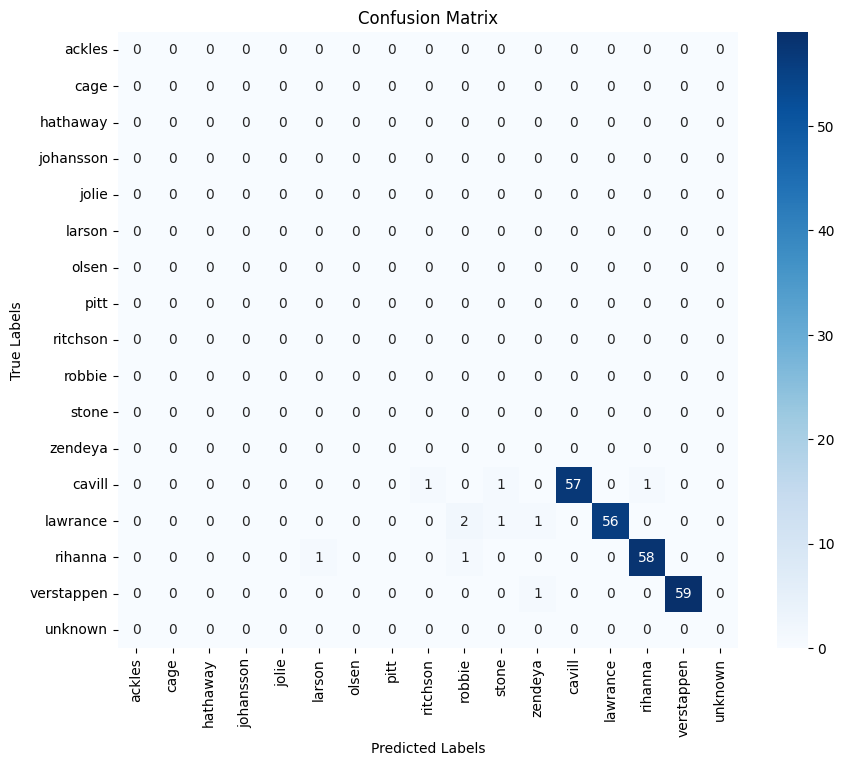

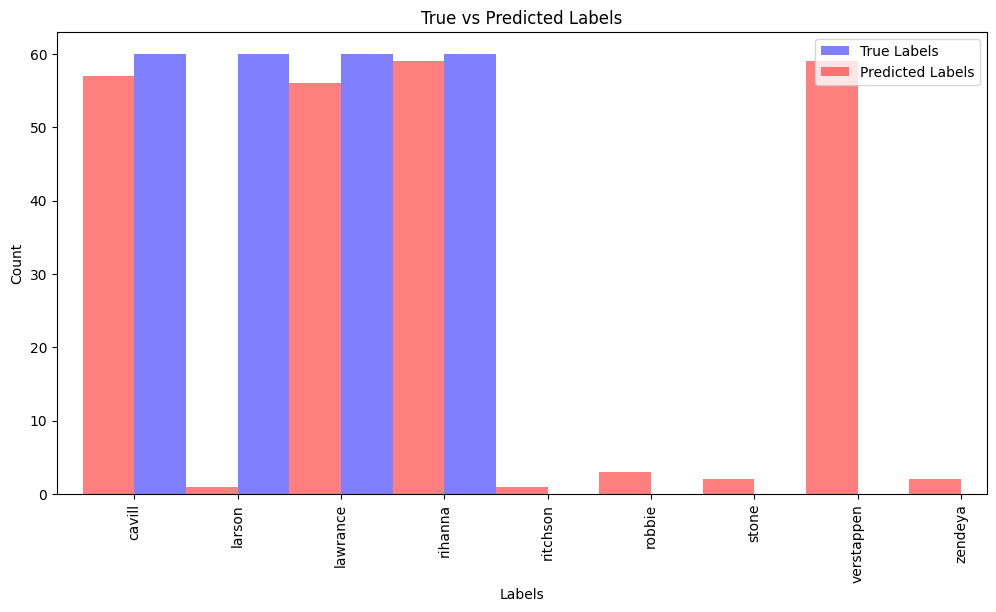

In [64]:
# Call the evaluation function after your training loop
gallery_json_path = 'gallery_embeddings.json' 
evaluate_model_and_update_gallery(model, val_dataset, gallery_json_path, device)
evaluate_model_and_preditc(model, val_dataset, gallery_json_path, device)

Loaded gallery embeddings: 16 persons
Created probe embeddings: 4 persons
Total validation images processed: 240
Person: cavill, Max Similarity: 1.0
Person: lawrance, Max Similarity: 0.9999999403953552
Person: rihanna, Max Similarity: 0.9999999403953552
Person: verstappen, Max Similarity: 1.0
Updated gallery embeddings: 16 persons
